In [25]:
# Dependencies and Setup
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#File Paths
clinical_trial_data_csv = os.path.join("data/clinicaltrial_data.csv")
mouse_drug_data_csv = os.path.join("data/mouse_drug_data.csv")

# Create DataFrames from the csv files
clinical_data_df = pd.read_csv(clinical_trial_data_csv )
mouse_data_df = pd.read_csv(mouse_drug_data_csv )

#Find the duplicate mice 
drop_mouse_id = clinical_data_df.loc[clinical_data_df.duplicated(subset=['Mouse ID', 'Timepoint']),'Mouse ID'].unique()

#Drop the duplicate mice from the clinical_trial_data.csv and mouse_drug_data.csv files. 
#And check output on csv file using "clean_clinical_df.to_csv('clean_clinical_data.csv', encoding='utf-8', index=False)"
clean_clinical_df = clinical_data_df[clinical_data_df['Mouse ID'].isin(drop_mouse_id)==False]
clean_mouse_df = mouse_data_df[mouse_data_df['Mouse ID'].isin(drop_mouse_id)==False]

# Merge the two DataFrames together based on 'Mouse ID'.
all_data = pd.merge(clean_clinical_df, clean_mouse_df, on="Mouse ID")

# Sort based on Timepoint
data_by_time = all_data.sort_values("Timepoint", ascending=True)

#Reset the index
all_data_by_time = data_by_time.reset_index()
del all_data_by_time['index']
all_data_by_time.head()



,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug
0,b128,0,45.0,0,Capomulin
1,v409,0,45.0,0,Placebo
2,u946,0,45.0,0,Propriva
3,w140,0,45.0,0,Zoniferol
4,a577,0,45.0,0,Infubinol


## Tumor Response to Treatment

In [26]:
#Drop the metastatic sites column
tumor_volume_data = all_data_by_time.drop('Metastatic Sites', axis=1)

#Pivot the table to make 'Drug' the index and get the means of the tumor volume.
treatment_grps = tumor_volume_data.pivot_table(tumor_volume_data, index=['Drug','Timepoint'], aggfunc='mean')

#Groupby treatment and get the means of the tumor volume and set the 'Drug' as the index.
means_tumor_vol = tumor_volume_data.pivot_table(tumor_volume_data, index=['Drug','Timepoint'], aggfunc='mean')

# Get the standard error of the mean for the tumor volumes over each timepoint 
sem_tumor_vol = tumor_volume_data.pivot_table(tumor_volume_data, index=['Drug','Timepoint'], aggfunc='sem')

#Make a new df for tumor volume to get difference between rows in the tumor volume.
tumor_vol = treatment_grps
tumor_vol['Tumor Volume Change (mm3)'] = tumor_vol.groupby('Drug')['Tumor Volume (mm3)'].diff()

#Drop the tumor volume column
tumor_vol_change = tumor_vol.drop('Tumor Volume (mm3)', axis=1)

#Fill in the NaN values with '0'.
tumor_vol_change.fillna(0, inplace=True)
tumor_vol_change.head()

Tumor Volume Change (mm3)
Drug      Timepoint                           
Capomulin 0                           0.000000
          5                          -0.733914
          10                         -1.181796
          15                         -1.019973
          20                         -1.347992

In [27]:
#Pivot the to get the SEM and Means for tumor volume.  '
sem_chart = sem_tumor_vol.pivot_table('Tumor Volume (mm3)', ['Timepoint'],'Drug' )

tumor_vol_chart = treatment_grps.pivot_table('Tumor Volume (mm3)', ['Timepoint'],'Drug' )
tumor_vol_chart.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.168130,43.944859,47.470830,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,48.938560,42.531957,49.335368,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,50.891769,41.495061,51.448025,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.127384,40.238325,53.970080,53.170334


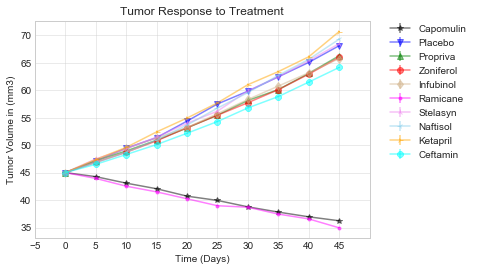

In [29]:
# Set the x_axis, colors, makers, and xlim for the line graphs with drugs in the legend.
x_axis = np.arange(0, 50, 5)
drugs = tumor_volume_data["Drug"].unique()
count = np.arange(0,len(drugs))
plt.xlim(0,50)

colors = ['black','blue','green','red','tan','magenta','violet','skyblue','orange','aqua']
markers = ['*','v','^','o','d','.','2','3','4','8']    

plt.style.use('seaborn-whitegrid')
plt.title("Tumor Response to Treatment")
plt.xlabel("Time (Days)")
plt.ylabel("Tumor Volume in (mm3)")
plt.grid(alpha = 0.5)
for i in count:
    standard_errors = stats.sem(sem_chart[drugs[i]])
    plt.errorbar(x_axis, tumor_vol_chart[drugs[i]], yerr = standard_errors, marker= markers[i], color= colors[i], alpha = 0.5, label = drugs[i])
plt.legend(bbox_to_anchor=(1.05,1),loc= 2, borderaxespad = 0.)
plt.xticks(np.arange(min(x_axis)-5, max(x_axis)+5, 5.0))
plt.savefig('metasticspreadduringtreatment_line1.png')
plt.show()

In [30]:
#Drop the tumor volume from the cleaned data frame.
metastatic_df = all_data_by_time.drop('Tumor Volume (mm3)', axis=1)

#Pivot the table to make 'Drug' the index and get the mean and SEM on the metastatic sites over time.
metastatic_avg = metastatic_df.pivot_table(metastatic_df, index=['Drug','Timepoint'], aggfunc='mean')
metastatic_sem = metastatic_df.pivot_table(metastatic_df, index=['Drug','Timepoint'], aggfunc='sem')

#Pivot the df so 'Timepoint' is the index for the averages and SEM. 
metastatic_sem_chart = metastatic_sem.pivot_table('Metastatic Sites', ['Timepoint'],'Drug' )
metastatic_avg_chart = metastatic_avg.pivot_table('Metastatic Sites', ['Timepoint'],'Drug' )
metastatic_avg_chart

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.347826,0.120000,0.260870,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.619048,0.250000,0.523810,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.800000,0.333333,0.809524,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.947368,1.294118
25,0.818182,1.500000,1.277778,1.631579,1.500000,1.941176,1.384615,0.652174,1.166667,1.687500
30,1.090909,1.937500,1.588235,2.055556,2.066667,2.266667,1.666667,0.782609,1.411765,1.933333
35,1.181818,2.071429,1.666667,2.294118,2.266667,2.642857,2.333333,0.952381,1.533333,2.285714
40,1.380952,2.357143,2.100000,2.733333,2.466667,3.166667,2.777778,1.100000,1.583333,2.785714


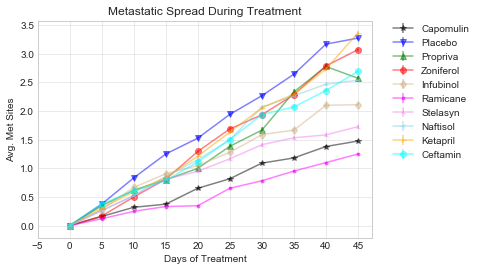

In [31]:

# Set the x_axis, colors, makers, and xlim for the line graphs with drugs in the legend.# Set t 
x_axis = np.arange(0, 50, 5)
drugs = all_data_by_time["Drug"].unique()
count = np.arange(0,len(drugs))

colors = ['black','blue','green','red','tan','magenta','violet','skyblue','orange','aqua']
markers = ['*','v','^','o','d','.','2','3','4','8']    
plt.style.use('seaborn-whitegrid')
plt.title("Metastatic Spread During Treatment")
plt.xlabel("Days of Treatment")
plt.ylabel("Avg. Met Sites")
plt.grid(alpha = 0.5)
for i in count:
    chart_data = stats.sem(metastatic_sem_chart[drugs[i]])
    plt.errorbar(x_axis, metastatic_avg_chart[drugs[i]], yerr = chart_data, marker= markers[i], color= colors[i], alpha = 0.5, label = drugs[i])
plt.legend(bbox_to_anchor=(1.05,1),loc= 2, borderaxespad = 0.)
plt.xticks(np.arange(min(x_axis)-5, max(x_axis)+5, 5.0))
plt.savefig('metasticspreadduringtreatment_line1.png')
plt.show()

## Metastatic Response to Treatment

In [32]:
#Drop the tumor volume from the cleaned data frame.
metastatic_df = all_data_by_time.drop('Tumor Volume (mm3)', axis=1)

#Pivot the table to make 'Drug' the index and get the mean and SEM on the metastatic sites over time.
metastatic_avg = metastatic_df.pivot_table(metastatic_df, index=['Drug','Timepoint'], aggfunc='mean')
metastatic_sem = metastatic_df.pivot_table(metastatic_df, index=['Drug','Timepoint'], aggfunc='sem')

#Pivot the df so 'Timepoint' is the index for the averages and SEM. 
metastatic_sem_chart = metastatic_sem.pivot_table('Metastatic Sites', ['Timepoint'],'Drug' )
metastatic_avg_chart = metastatic_avg.pivot_table('Metastatic Sites', ['Timepoint'],'Drug' )
metastatic_avg_chart

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.347826,0.120000,0.260870,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.619048,0.250000,0.523810,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.800000,0.333333,0.809524,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.947368,1.294118
25,0.818182,1.500000,1.277778,1.631579,1.500000,1.941176,1.384615,0.652174,1.166667,1.687500
30,1.090909,1.937500,1.588235,2.055556,2.066667,2.266667,1.666667,0.782609,1.411765,1.933333
35,1.181818,2.071429,1.666667,2.294118,2.266667,2.642857,2.333333,0.952381,1.533333,2.285714
40,1.380952,2.357143,2.100000,2.733333,2.466667,3.166667,2.777778,1.100000,1.583333,2.785714


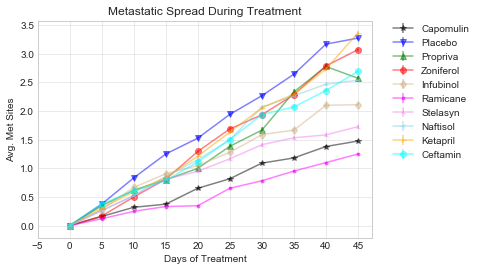

In [33]:
# Set the x_axis, colors, makers, and xlim for the line graphs with drugs in the legend.
x_axis = np.arange(0, 50, 5)
drugs = all_data_by_time["Drug"].unique()
count = np.arange(0,len(drugs))

colors = ['black','blue','green','red','tan','magenta','violet','skyblue','orange','aqua']
markers = ['*','v','^','o','d','.','2','3','4','8']    
plt.style.use('seaborn-whitegrid')
plt.title("Metastatic Spread During Treatment")
plt.xlabel("Days of Treatment")
plt.ylabel("Avg. Met Sites")
plt.grid(alpha = 0.5)
for i in count:
    chart_data = stats.sem(metastatic_sem_chart[drugs[i]])
    plt.errorbar(x_axis, metastatic_avg_chart[drugs[i]], yerr = chart_data, marker= markers[i], color= colors[i], alpha = 0.5, label = drugs[i])
plt.legend(bbox_to_anchor=(1.05,1),loc= 2, borderaxespad = 0.)
plt.xticks(np.arange(min(x_axis)-5, max(x_axis)+5, 5.0))
plt.savefig('metasticspreadduringtreatment_line2.png')
plt.show()

## Survival Rates

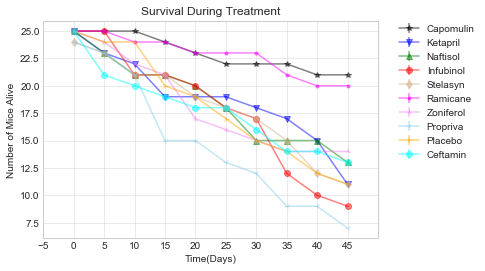

In [34]:
#Drop the metastatic sites and tumor volume
mouse_surviving = metastatic_df.drop('Metastatic Sites', axis=1)

#Pivot the table to make 'Drug' the index and get the avg number of metastatic sites over time.
mouse_survival = mouse_surviving.pivot_table(mouse_surviving, index=['Drug','Timepoint'], aggfunc='count')

#Change the name of "Mouse ID" to "Mouse Count"
mouse_survival_df = mouse_survival.rename(columns={"Mouse ID": "Mouse Count"})

#Pivot the df so that 'Timepoint' is the index 
mouse_survival_chart = mouse_survival_df.pivot_table('Mouse Count', ['Timepoint'],'Drug' )

# Set the x_axis, colors, makers, and xlim for the line graphs with drugs in the legend.
x_axis = np.arange(0, 50, 5)
colors = ['black','blue','green','red','tan','magenta','violet','skyblue','orange','aqua']
markers = ['*','v','^','o','d','.','2','3','4','8']    
plt.xlim(0,50)
drugs=all_data["Drug"].unique()
count = np.arange(0,len(drugs))

plt.style.use('seaborn-whitegrid')
plt.title("Survival During Treatment")
plt.xlabel("Time(Days)")
plt.ylabel("Number of Mice Alive")
plt.grid(alpha = 0.5)
for i in count:
    plt.errorbar(x_axis, mouse_survival_chart[drugs[i]], yerr = chart_data, marker= markers[i], color= colors[i], alpha = 0.5, label = drugs[i])
plt.legend(bbox_to_anchor=(1.05,1),loc= 2, borderaxespad = 0.)
plt.xticks(np.arange(min(x_axis)-5, max(x_axis)+5, 5.0))
plt.savefig('survivalduringtreatment_line2.png')
plt.show()


In [35]:
#Present the data in terms of "Survival Rate (%)".
percent_surviving = (1-(mouse_survival_chart.iloc[0]- mouse_survival_chart)/mouse_survival_chart.iloc[0])*100
percent_surviving

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000,100.0
5,100.0,84.0,100.0,92.0,92.0,96.0,95.833333,100.0,95.833333,96.0
10,100.0,80.0,84.0,88.0,84.0,96.0,87.500000,96.0,87.500000,88.0
15,96.0,76.0,84.0,76.0,84.0,80.0,62.500000,96.0,87.500000,84.0
20,92.0,72.0,80.0,76.0,80.0,76.0,62.500000,92.0,79.166667,68.0
25,88.0,72.0,72.0,76.0,72.0,68.0,54.166667,92.0,75.000000,64.0
30,88.0,64.0,68.0,72.0,60.0,60.0,50.000000,92.0,70.833333,60.0
35,88.0,56.0,48.0,68.0,60.0,56.0,37.500000,84.0,62.500000,56.0
40,84.0,56.0,40.0,60.0,60.0,48.0,37.500000,80.0,50.000000,56.0


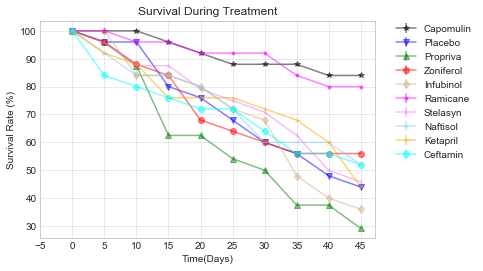

In [36]:
# Set the x_axis, colors, makers, and xlim for the line graphs with drugs in the legend.
x_axis = np.arange(0, 50, 5)
colors = ['black','blue','green','red','tan','magenta','violet','skyblue','orange','aqua']
markers = ['*','v','^','o','d','.','2','3','4','8']    
#plt.xlim(0,50)
drugs = all_data_by_time["Drug"].unique()
count = np.arange(0,len(drugs))

plt.style.use('seaborn-whitegrid')
plt.title("Survival During Treatment")
plt.xlabel("Time(Days)")
plt.ylabel("Survival Rate (%)")
plt.grid(alpha = 0.5)
for i in count:
    plt.errorbar(x_axis, percent_surviving[drugs[i]], yerr = chart_data, marker= markers[i], color= colors[i], alpha = 0.5, label = drugs[i])
plt.legend(bbox_to_anchor=(1.05,1),loc= 2, borderaxespad = 0.)
plt.xticks(np.arange(min(x_axis)-5, max(x_axis)+5, 5.0))
plt.savefig('survivalduringtreatment_line3.png')
plt.show()

## Summary Bar Graph

In [37]:
# Get the first and last rows of the tumor volume chart
short_tumor_vol_chart = tumor_vol_chart.iloc[[0,-1]]

# Get % tumur volume change
percent_tumor_vol_diff = ((short_tumor_vol_chart -short_tumor_vol_chart.iloc[0])/short_tumor_vol_chart.iloc[0])*100

# Get the last row.
percent_diff = percent_tumor_vol_diff.loc[1:]
percent_diff.sum()


Drug
Capomulin   -19.475303
Ceftamin     42.516492
Infubinol    46.123472
Ketapril     57.028795
Naftisol     53.923347
Placebo      51.297960
Propriva     47.241175
Ramicane    -22.320900
Stelasyn     52.085134
Zoniferol    46.579751
dtype: float64

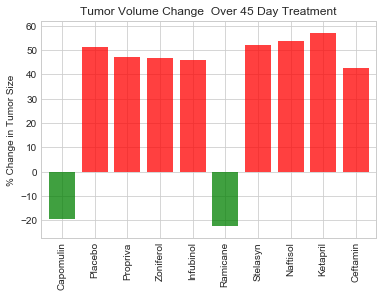

In [38]:
# Create a bar graph with tumor growth in red and tumor shrinkage in red. # Create 
plt.style.use('seaborn-whitegrid')
performance = {}
for x in count:
    performance[drugs[x]] = float(percent_diff[drugs[x]])
x_axis = np.arange(0, len(drugs))
tick_locations = []
for x in x_axis:
    tick_locations.append(x + 0.4)
plt.xlim(-0.25, len(drugs))
plt.ylim(min(performance.values()) - 5, max(performance.values()) + 5)
plt.title("Tumor Volume Change  Over 45 Day Treatment")
plt.ylabel("% Change in Tumor Size")
bar_colors = pd.Series(list(performance.values()))
bar_colors = bar_colors > 0
bar_colors = bar_colors.map({True: "Red", False: "Green"})
plt.xticks(tick_locations, performance, rotation="vertical")
plt.bar(x_axis, performance.values(), color=bar_colors, alpha=0.75, align="edge")
plt.savefig('tumorgrowthandshortage_bar1.png')
plt.show()

## Summary

1. Comparison of all the chemotherapeutic drugs over 45 days revealed that Capomulin and Ramicane were more effective at reducing tumor volume by 19.5% and 22.3%, respectively.
2. Over 45 days Capomulin and Ramicane, had a greater capacity to reduce the average number of metastatic sites, 1.5 and 1.25, respectively, while other chemotherpeutic drugs have an average of 2-3 times more metastatic sites.

3. Finally, treatment with Capomulin and Ramicane resulted in a better mouse survival, 84% and 80%, respectively, over 45 days than with the other treatments, which ranged between 36-56% survival.